In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
from os.path import join as pjoin
from glob import glob
sys.path.append('..')

In [5]:
import cv2
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from utils.commands import unzip, mkdir, call, count_file, KaggleCLI, execute_in, unzip_all

cli = KaggleCLI('dogs-vs-cats-redux-kernels-edition')

## Data preprocess

In [7]:
data_path = pjoin(os.getcwd(), 'data')
model_path = pjoin(os.getcwd(), 'models')
sample_path = pjoin(data_path, 'sample')
train_name = 'train'
valid_name = 'valid'
test_name = 'ttest'

In [3]:
cli.download_data()

In [8]:
unzip_all(data_path)

In [37]:
categories = ['dog', 'cat']
for folder in [train_name, test_name, valid_name]:
    for ctg in categories:
        mkdir(pjoin(data_path, folder, ctg))
        mkdir(pjoin(sample_path, folder, ctg))

In [38]:
def move_data_to_category():
    call("mv cat.* cat")
    call('mv dog.* dog')

execute_in(pjoin(data_path, train_name), move_data_to_category)

In [39]:
def settle_data():
    train_cat, valid_cat, train_dog, valid_dog = train_test_split(os.listdir('train/cat'), os.listdir('train/dog'), test_size=0.2)
    valid_cat, test_cat, valid_dog, test_dog = train_test_split(valid_cat, valid_dog, test_size=0.4)
    
    strt = {
        train_name: {
            'dog': train_dog,
            'cat': train_cat,
        },
        valid_name: {
            'dog': valid_dog,
            'cat': valid_cat,
        },
        test_name: {
            'dog': test_dog,
            'cat': test_cat,
        }
    }
    
    for name, ds in strt.iteritems():
        if name == train_name:
            continue
        for ctg, data in ds.iteritems():
            for d in data:
                call('mv {} {}'.format(pjoin(train_name, ctg, d), pjoin(name, ctg)))
    
    for name, ds in strt.iteritems():
        for ctg, data in ds.iteritems():
            for d in data[:100]:
                call('cp {} {}'.format(pjoin(name, ctg, d), pjoin(sample_path, name, ctg)))
   

execute_in(data_path, settle_data)

In [72]:
import matplotlib.pyplot as plt

def plots(images, columns=4):
    fig = plt.figure(figsize=(20, 20))
#     fig.add_subplot(1, 0, 0)
    rows = int(len(images) / columns) + 1
    
    for idx, img in enumerate(images):
        fig.add_subplot(rows, columns, idx+1)
        plt.imshow(img)
    plt.show()


In [41]:
image_pathes =[pjoin(data_path, train_name, 'dog', img_name) for img_name in os.listdir(pjoin(data_path, train_name, 'dog'))[:10]]

In [43]:
images = [cv2.imread(ip) for ip in image_pathes]

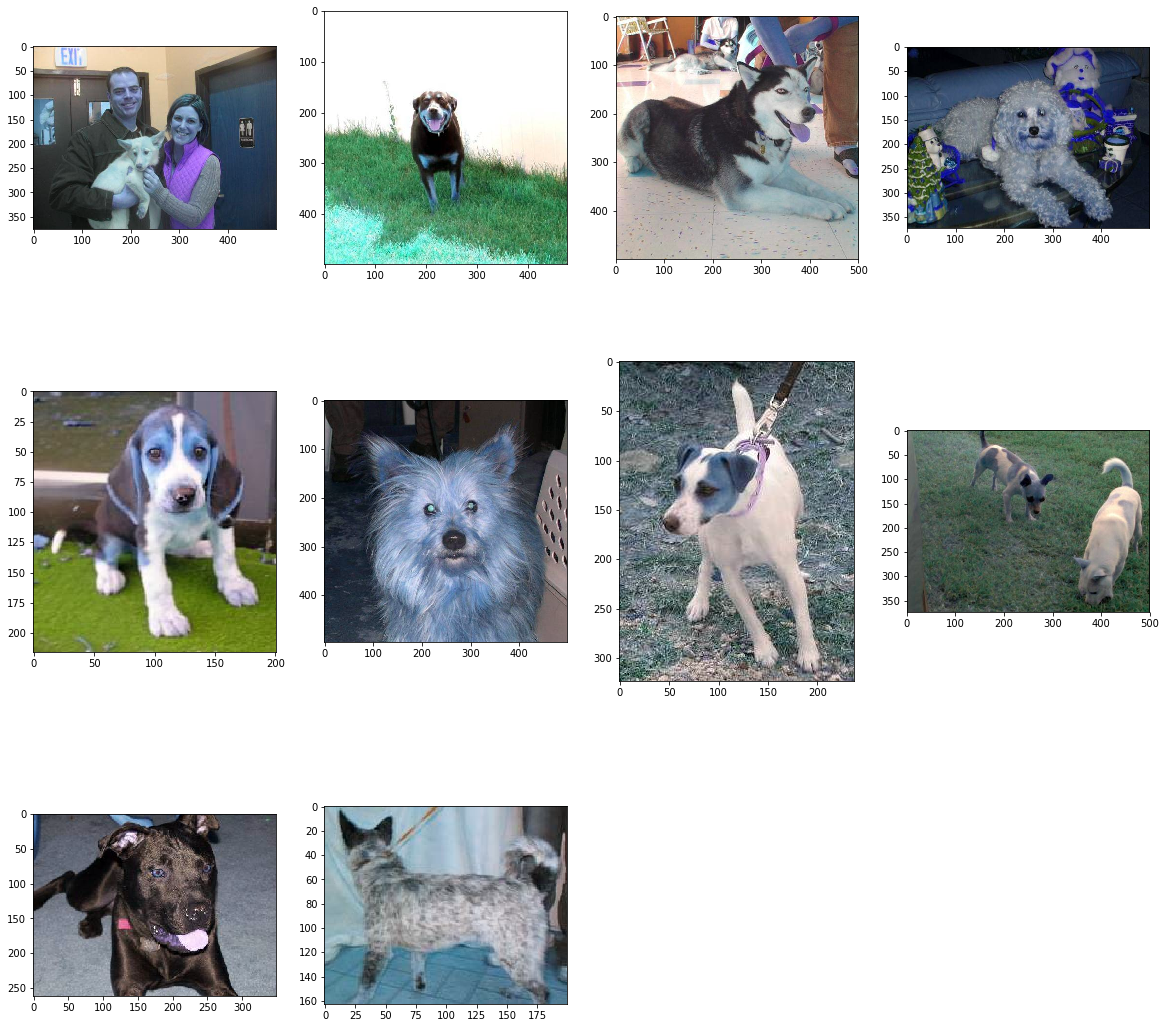

In [73]:
plots(images)

## Fine tune VGG

In [28]:
work_path = sample_path

In [29]:
from utils.pretrained_models import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [30]:
vgg_model = VGG16.get_model(2).model

In [31]:
batch_size=32

train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_flow = train_datagen.flow_from_directory(
        pjoin(work_path, train_name),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
valid_flow = valid_datagen.flow_from_directory(
        pjoin(work_path, valid_name),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
test_flow = test_datagen.flow_from_directory(
        pjoin(work_path, test_name),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 100 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [21]:
for l in vgg_model.layers[:-1]:
    l.trainable = False

In [22]:
train_steps = train_flow.samples // batch_size
valid_steps = valid_flow.samples // batch_size
epochs = 3

vgg_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
vgg_model.fit_generator(
        train_flow,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=valid_flow,
        validation_steps=valid_steps)

Epoch 1/3
3/3 [==============================] - 4s 1s/step - loss: 0.0644 - acc: 0.9786 - val_loss: 6.7780 - val_acc: 0.5208
Epoch 2/3
3/3 [==============================] - 1s 400ms/step - loss: 9.1807e-06 - acc: 1.0000 - val_loss: 7.7700 - val_acc: 0.4412
Epoch 3/3
3/3 [==============================] - 1s 340ms/step - loss: 2.4017e-05 - acc: 1.0000 - val_loss: 6.5054 - val_acc: 0.5441


In [23]:
vgg_model.evaluate_generator(test_flow)

UnboundLocalError: local variable 'outs' referenced before assignment

In [17]:
vgg_model.predict_generator(test_flow)

array([[9.9922144e-01, 7.7851169e-04],
       [5.2542412e-03, 9.9474573e-01],
       [9.4702196e-01, 5.2978039e-02],
       [9.9267840e-01, 7.3215407e-03],
       [1.6351958e-04, 9.9983644e-01],
       [9.2523640e-01, 7.4763611e-02],
       [2.1216381e-01, 7.8783619e-01],
       [1.9384778e-04, 9.9980623e-01],
       [9.9969661e-01, 3.0338240e-04],
       [1.7961633e-04, 9.9982041e-01]], dtype=float32)